In [1]:
import torch
import pytest
import sys
import torch.nn.functional as F

sys.path.append('..')

from pylon.tnorm_solver import *
from pylon.lazy_tensor import LazyTensor, ConstShapedLazyTensor
from pylon.shaped_lazy_solver import ProductTNormSolver, GodelTNormSolver, LukasiewiczTNormSolver 
from pylon.lazy_circuit_solver import SemanticLossCircuitSolver

from pylon.constraint import constraint
sys.setrecursionlimit(1500)

In [2]:
class Net(torch.nn.Module):
    '''Neural network with a single input (fixed) and two categorical outputs.'''

    def __init__(self, num_labels, w=None):
        super().__init__()
        self.num_labels = num_labels
        if w is not None:
            self.w = torch.nn.Parameter(
                torch.tensor(w).float().view(
                    self.num_labels*2, 1))
        else:
            self.w = torch.nn.Parameter(
                torch.rand(self.num_labels*2, 1))

    def forward(self, x):
        return torch.matmul(self.w, x).view(2, self.num_labels)

net_multi = Net(3)
net_binary = Net(2)
    
def train(net, constraint=None, epoch=100):
    x = torch.tensor([1.0])
    y = torch.tensor([0, 1])
    y0 = F.softmax(net(x), dim=-1)
    opt = torch.optim.SGD(net.parameters(), lr=0.1)

    for _ in range(epoch):
        opt.zero_grad()
        y_logit = net(x)
        loss = F.cross_entropy(y_logit[1:], y[1:])
        if constraint is not None:
            loss += constraint(y_logit)
        loss.backward()
        opt.step()
    return net, y0
 
    
a = {"key": 1}
def xor(y):
    return (y[0].logical_and(y[a['key']].logical_not())).logical_or(y[0].logical_not().logical_and(y[a['key']]))
    return (y[0] and not y[a['key']]) or (not y[0] and y[a['key']])

    
def test_xor_binary(net_binary, solver):    
    num_tries = 10
    success = 0
    for i in range(num_tries):
        cons = constraint(xor, solver)

        net, y0 = train(net_binary, cons)
        x = torch.tensor([1.0])
        y = F.softmax(net(x), dim=-1)

        if y[0, 0] > 0.75 and y[0, 1] < 0.25:
            success += 1
        assert y[1, 0] < 0.25 and y[1, 1] > 0.75
    print(f'success {success} num_tries {num_tries}')
    assert success == num_tries

def test_eq_multi(net_multi, solver):
    num_tries = 5  # since it's random
    success = 0
    for i in range(num_tries):
        cons = constraint(lambda y: y[0] == y[1], solver)
        net, y0 = train(net_multi, cons)
        x = torch.tensor([1.0])
        y = F.softmax(net(x), dim=-1)
        if y[0, 1] > 0.8:
            success += 1
        assert y[1, 1] > 0.9
    print(f'success {success} num_tries {num_tries}')
    assert success == num_tries    

In [3]:
x = torch.tensor([1.0])
y_logit = net_binary(x)
print("y_logit", y_logit)
torch.softmax(y_logit, dim=-1) 

y_logit tensor([[0.4477, 0.1499],
        [0.8375, 0.3147]], grad_fn=<ViewBackward>)


tensor([[0.5739, 0.4261],
        [0.6278, 0.3722]], grad_fn=<SoftmaxBackward>)

In [4]:
solvers = [SemanticLossCircuitSolver()]
#            GodelTNormSolver(),LukasiewiczTNormSolver(),ProductTNormSolver()]
for solver in solvers: 
    test_eq_multi(net_multi, solver)

success 5 num_tries 5


In [5]:
solvers = [SemanticLossCircuitSolver()]
#            GodelTNormSolver(),LukasiewiczTNormSolver(),ProductTNormSolver()]
for solver in solvers: 
    test_xor_binary(net_binary, solver)

success 10 num_tries 10


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict

class PlotHelper():
    def __init__(self):
        self.reset()

    def reset(self):
        self._f = None
        self._ax = None
        self.kvals = defaultdict(list)

    def add(self, **kval):
        for k, v in kval.items():
            self.kvals[k].append(v)

    @property
    def fig(self):
        if self._f is None:
            self.new()
        return self._f

    @property
    def ax(self):
        if self._ax is None:
            self.new()
        return self._ax

    def new(self):
        self._f, self._ax = plt.subplots(1,1)
        plt.ion()
        self.fig.show()

    def show(self):
        names = []
        self.ax.clear()
        for k, v in self.kvals.items():
            names.append(k)
            self.ax.plot(v)
        self.ax.legend(names)
        self.fig.canvas.draw()

In [7]:
from itertools import chain


class Example_Net(torch.nn.Module):
    def __init__(self, w=None):
        super().__init__()
        if w is not None:
            self.w = torch.nn.Parameter(torch.tensor(w).float().view(6, 1))
        else:
            self.w = torch.nn.Parameter(torch.rand(6, 1))

    def forward(self, x):
        return torch.matmul(self.w, x).view(3, 2)


In [8]:
from pylon.brute_force_solver import *

def get_sampling_solvers(num_samples):
    return [
        SatisfactionBruteForceSolver(), ViolationBruteForceSolver(),]

def test_bruteforce_xor_binary(net_binary):
    solvers = get_sampling_solvers(num_samples=10)
    for solver in solvers:
        num_tries = 5  # since it's random
        success = 0
        for i in range(num_tries):
            cons = constraint(xor, solver)

            net, y0 = train(net_binary, cons)
            x = torch.tensor([1.0])
            y = F.softmax(net(x), dim=-1)

            if y[0, 0] > 0.75 and y[0, 1] < 0.25:
                success += 1
            assert y[1, 0] < 0.25 and y[1, 1] > 0.75

        print(f'success {success} num_tries {num_tries}')
        assert success == num_tries

# test_bruteforce_xor_binary(net_binary)

In [9]:
def experiment(func_ab):
    neta = Example_Net()
    netb = Example_Net()
    x = torch.tensor([1.])
    y = torch.tensor([0, 0, 1])
    opt = torch.optim.SGD(chain(neta.parameters(), netb.parameters()), lr=0.1)
    plot = PlotHelper()
    plot_loss = PlotHelper()
    cons = constraint(func_ab, ProductTNormSolver())

    ya_logit = neta(x)
    yb_logit = netb(x)
    oloss = F.cross_entropy(ya_logit[2:], y[2:])
    closs = cons(ya_logit, yb_logit)
    loss = oloss + closs
    loss.backward()
    ya_prob = torch.softmax(ya_logit, dim=-1)
    yb_prob = torch.softmax(yb_logit, dim=-1)
    
    num_samples = 500

    for _ in range(num_samples):
        ya_logit = neta(x)
        yb_logit = netb(x)
        oloss = F.cross_entropy(ya_logit[2:], y[2:])
        closs = cons(ya_logit, yb_logit)
        loss = oloss + closs
        loss.backward()
        ya_prob = torch.softmax(ya_logit, dim=-1)
        yb_prob = torch.softmax(yb_logit, dim=-1)
        plot.add(
            ya1=ya_prob[1,1].data, ya2=ya_prob[2,1].data, 
            yb1=yb_prob[1,1].data, yb2=yb_prob[2,1].data)
        plot_loss.add(oloss=oloss.data, closs=closs.data, loss=loss.data)
        opt.step()

    plot.show()
    plot_loss.show()

/Users/thy/research/pytorch-constraints/env/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


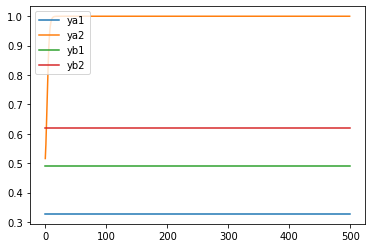

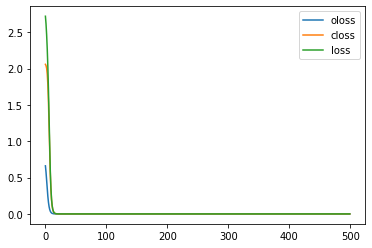

In [10]:
#
def and_ab_0(a, b):
    return (a[2]==b[1]).logical_and(b[1]==b[2]).logical_and(b[2]==a[1])

experiment(and_ab_0)

In [13]:
# equal case with cond and const
def func_ab(a, b):
    return a[b==0] == 1


neta = Example_Net()
netb = Example_Net()
x = torch.tensor([1.0])
y = torch.tensor([0, 0, 1])
opt = torch.optim.SGD(chain(neta.parameters(), netb.parameters()), lr=0.1)
plot = PlotHelper()
plot_loss = PlotHelper()
cons = constraint(func_ab, ProductTNormSolver())

ya_logit = neta(x)
yb_logit = netb(x)
oloss = F.cross_entropy(ya_logit[2:], y[2:])
closs = cons(ya_logit, yb_logit)
loss = oloss + closs
loss.backward()
ya_prob = torch.softmax(ya_logit, dim=-1)
yb_prob = torch.softmax(yb_logit, dim=-1)

num_samples = 500

for _ in range(num_samples):
    ya_logit = neta(x)
    yb_logit = netb(x)
    oloss = F.cross_entropy(ya_logit[2:], y[2:])
    closs = cons(ya_logit, yb_logit)
    loss = oloss + closs
    loss.backward()
    ya_prob = torch.softmax(ya_logit, dim=-1)
    yb_prob = torch.softmax(yb_logit, dim=-1)
    plot.add(
        ya1=ya_prob[1,1].data, ya2=ya_prob[2,1].data, 
        yb1=yb_prob[1,1].data, yb2=yb_prob[2,1].data)
    plot_loss.add(oloss=oloss.data, closs=closs.data, loss=loss.data)
    opt.step()

plot.show()
plot_loss.show()

LazyTensor:logical_or
  LazyTensor:logical_not
    LazyTensor:eq
      ConstShapedLazyTensor: index=1
      0


  LazyTensor:eq
    ConstShapedLazyTensor: index=0
    1




RuntimeError: bool value of Tensor with more than one value is ambiguous